# New York City COVID-19 Analysis

## Introduction

New York City is currently at the epicenter of US COVID-19 pandemic. This project was created to observe the number of cases, hospitalizations and deaths occuring in this densely populated city of 8 million residents.

The data is provided by the NYC Department of Health's [COVID-19 Daily Data Summaries](https://www1.nyc.gov/site/doh/covid/covid-19-providers.page).

The PDFs were scraped using a Python script twice a day and added to an existing CSV file of all previous daily summaries.

In [1]:
import math
import pandas as pd
import geopandas as gpd
import numpy as np
import fiona
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime

## Useful Functions

Since I am dealing with multiple dataframes in this analysis and creating multiple figures, I wrote some functions to get the data into the format I needed. 

In [2]:
# Function that spatializes the COVID data
def add_geom(df, geom):
    if df.name == "deaths":
        geom_df = df.loc[(df['Category'] == 'Borough') & (df['Underlying Conditions'] == 'Total')]
        geom_df = geom_df.drop(columns='Underlying Conditions')
    else:
        geom_df = df.loc[df['Category'] == 'Borough']
    geom_df = geom_df.drop(columns='Category')
    geom = geom.rename(columns={'boro_name': 'Borough'})
    geom_df = geom.join(geom_df.set_index('Variable'), on='Borough')
    return geom_df

In [3]:
# Function that makes a tidy subtable from the desired category 
def subtable(df, category):
    if df.name == "deaths":
        sub_df = df.loc[(df['Category'] == category) & (df['Underlying Conditions'] == 'Total')]
        sub_df = sub_df.drop(columns='Underlying Conditions')
    else:
        sub_df = df.loc[df['Category'] == category]
    sub_df = sub_df.drop(columns='Category')
    sub_df = sub_df.rename(columns={'Variable': 'Date'})
    sub_df = pd.DataFrame(sub_df).set_index('Date')
    sub_df = sub_df.transpose()
    sub_df.name = category
    return sub_df

In [4]:
# Function that returns the highest value out of the 5 boroughs
def max_boro_num(df):
    only_boros = df.loc[df['Category'] == 'Borough']
    only_nums = only_boros.select_dtypes(include=[np.number])
    return only_nums.max().max()

# Function that rounds a number up to the nearest given place value
def round_up(num, p_val):
    return int(math.ceil(num / p_val)) * p_val

## Acquiring the Data

The COVID-19 cases reported by DOH are grouped into categories: `Age Group`, `Age 50 and over`, `Sex` and `Borough`. The following data frame came from a CSV file created using a Python script I wrote, `crawler.py`. A notebook of that script can be found named __nyc-covid-crawler__.

In [5]:
# Read in the three CSV files
cases_hist = pd.read_csv('covid_cases.csv', index_col=0)
hosp_hist = pd.read_csv('covid_hosp.csv', index_col=0)
deaths_hist = pd.read_csv('covid_deaths.csv', index_col=0)

# Name the dataframes for easy identification
cases_hist.name = "positive cases"
hosp_hist.name = "hospitalizations"
deaths_hist.name = "deaths"

cases_hist

,Category,Variable,2020-03-26,2020-03-27,2020-03-28,2020-03-29
0,NaN,Total,23112,26697,30765,33474
1,NaN,Median Age (Range),47,47,48,48
2,Age Group,0 to 17,495,543,591,619
3,Age Group,18 to 44,10145,11617,13213,14233
4,Age Group,45 to 64,7869,9158,10596,11577
5,Age Group,65 to 74,2627,3034,3571,3954
6,Age Group,75 and over,1935,2286,2724,3020
7,Age 50 and over,Yes,10452,12209,14279,15706
8,Age 50 and over,No,12619,14429,16416,17697
9,Sex,Female,10124,11792,13592,14837


Since the daily reports contain geographic aggregations, I can map the coronavirus cases by the 5 boroughs. Although a smaller spatial resolution is preferable, you take what you can get. To spatialize the data, the three dataframes are each joined to the boroughs GeoJSON using a function I wrote called `add_geom`.

In [6]:
# Import borough booundary GeoJSON and set projection to NAD83
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON"
boroughs_wgs84 = gpd.read_file(url)
boroughs = boroughs_wgs84.to_crs({'init': 'epsg:2263'})

In [7]:
# Add the geometries to the coronavirus data.
cases_geo = add_geom(cases_hist, boroughs)
hosp_geo = add_geom(hosp_hist, boroughs)
deaths_geo = add_geom(deaths_hist, boroughs)

cases_geo

,boro_code,Borough,shape_area,shape_leng,geometry,2020-03-26,2020-03-27,2020-03-28,2020-03-29
0,2,Bronx,1186612478.27,462958.187578,"MULTIPOLYGON (((1012821.806 229228.265, 101278...",4243,4880,5752,6250
1,5,Staten Island,1623757282.78,325956.009,"MULTIPOLYGON (((970217.022 145643.332, 970227....",1330,1534,1781,1984
2,3,Brooklyn,1937593022.64,738745.842115,"MULTIPOLYGON (((1021176.479 151374.797, 102100...",6095,7091,8129,8887
3,4,Queens,3045878293.21,904188.424488,"MULTIPOLYGON (((1029606.077 156073.814, 102957...",7362,8529,9831,10737
4,1,Manhattan,636602658.887,361212.476098,"MULTIPOLYGON (((981219.056 188655.316, 980940....",4046,4627,5237,5582


## Data Analysis

Below is a choropleth map showing the current total number of confirmed positive cases in NYC by borough. A label with the number of deaths in each borough is also added.

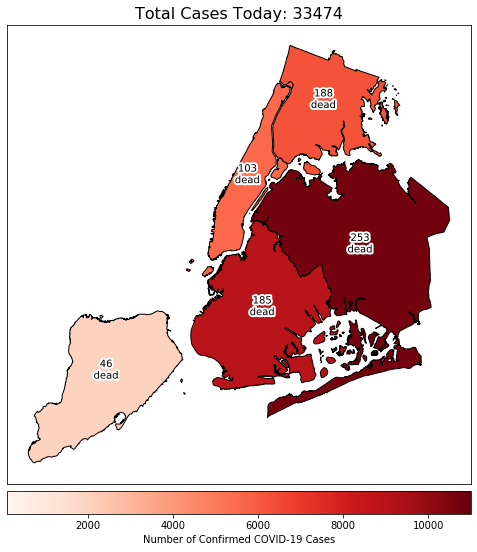

In [8]:
today = datetime.today().strftime('%Y-%m-%d')
vmax = round_up(max_boro_num(cases_hist), 1000)

fig, ax = plt.subplots(figsize=(9, 9))
total = cases_hist.loc[cases_hist['Variable'] == 'Total', today].values[0]
title = 'Total Cases Today: ' + str(total)
plt.title(title, size='16')
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.1)
cs_fig = cases_geo.plot(ax=ax, column=today, cmap='Reds', 
                        edgecolor='black', legend=True, 
                        cax = cax, vmin=100, vmax=vmax,
                        legend_kwds={'label': 'Number of Confirmed COVID-19 Cases', 
                                     'orientation': 'horizontal'})
ax.tick_params(left=0, labelleft=0, bottom=0, labelbottom=0)
deaths_geo.apply(lambda x: cs_fig.annotate(s='{:.0f}\ndead'.format(x[today]),
                                           xy=x.geometry.centroid.coords[0],
                                           ha='center', color='black',
                                           path_effects=[pe.withStroke(linewidth=4,
                                                                       foreground='white')]),
                axis=1)

plt.show()

The above code is rewritten into a for loop to create a grid of maps from when I started collecting this data on March 26, 2020. Below shows the gridded maps.

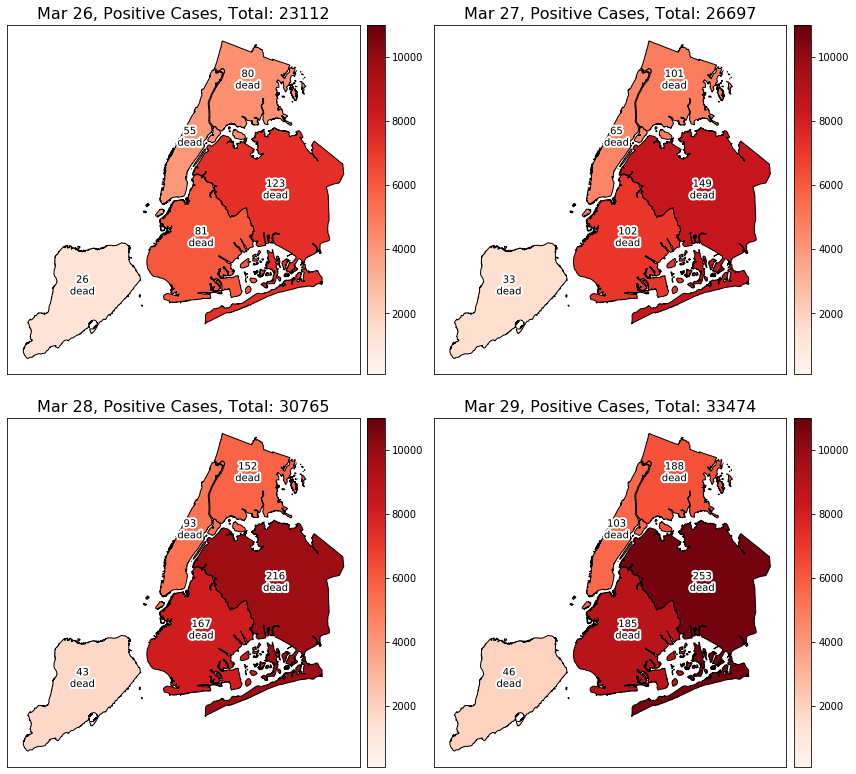

In [9]:
vmax = round_up(max_boro_num(cases_hist), 1000)
fig = plt.figure(figsize=(12, 12))
dates = cases_geo.columns[5:]
for i in range(len(dates)):
    date = dates[i]
    date_str = datetime.strptime(date, '%Y-%m-%d').strftime('%b %d')
    grid_nrow = round(len(dates) / 2)
    ax = fig.add_subplot(grid_nrow, 2, i + 1)
    total = cases_hist.loc[cases_hist['Variable'] == 'Total', date].values[0]
    title = date_str + ', Positive Cases, Total: ' + str(total)
    plt.title(title, size='16')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cs_fig = cases_geo.plot(ax=ax, column=date, cmap='Reds', 
                            edgecolor='black', legend=True, 
                            cax = cax, vmin=100, vmax=vmax)
    ax.tick_params(left=0, labelleft=0, bottom=0, labelbottom=0)
    deaths_geo.apply(lambda x: cs_fig.annotate(s='{:.0f}\ndead'.format(x[date]),
                                               xy=x.geometry.centroid.coords[0],
                                               ha='center', color='black',
                                               path_effects=[pe.withStroke(linewidth=4,
                                                                           foreground='white')]),
                    axis=1)
    plt.tight_layout()

plt.show()

Below is a line graph of the number of positive cases, hospitalizations and deaths scaled by `Age Group` from when I started collecting this data.

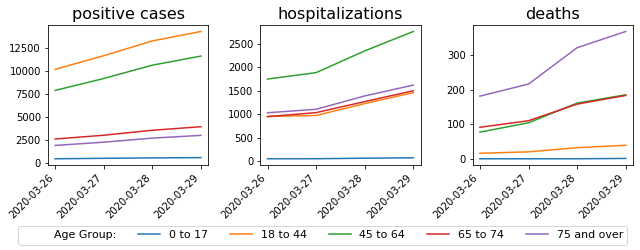

In [10]:
dataframes = [cases_hist, hosp_hist, deaths_hist]
fig = plt.figure(figsize=(9, 3.5))

for i in range(len(dataframes)):
    sub_df = subtable(dataframes[i], 'Age Group')
    
    ax = fig.add_subplot(1, 3, i + 1)
    sub_df.plot.line(ax=ax, legend=False)
    title = dataframes[i].name
    plt.title(title, size='16')
    plt.xticks(rotation=45, ha='right')

h, l = ax.get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]
handles = ph + h
labels = ["Age Group:"] + l
lgd = fig.legend(handles, labels, bbox_to_anchor=(0.02, 0),
                 loc='lower left', ncol=6, prop={'size': 11})
fig.tight_layout()
fig.subplots_adjust(bottom=0.33)

plt.show()

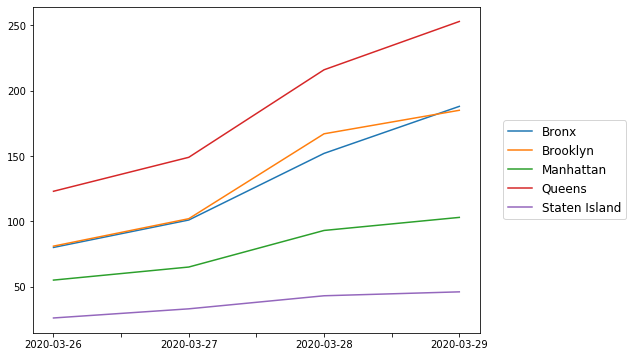

In [11]:
age_df = subtable(deaths_hist, 'Borough')

age_df.plot.line(figsize=(8, 6))
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', 
           prop={'size': 12})

plt.show()